In [1]:
import numpy as np # linear algebra
import pandas as pd

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD


In [3]:
import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

# Identifying Metastatic Cancer using CNN

##  Introduction

In this notebook, we will use a Convolutional Neural Network (CNN) to tackle a binary classification problem, identifying metastatic cancer from small image patches extracted from larger digital pathology scans. Each image patch is 96x96 pixels in size. The dataset consists of 220,025 images for training and 57,458 images for testing.

In [4]:
# copy kaggle.json to /root/.kaggle/ folder so that kaggle cli can access it.
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [04:57<00:00, 23.6MB/s]
100% 6.31G/6.31G [04:57<00:00, 22.8MB/s]


In [6]:
! unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffa

In [7]:
print(str(len(os.listdir('train'))) + " images for training")
print(str(len(os.listdir('test'))) + " images for testing")

220025 images for training
57458 images for testing


## Exploratory Data Analysis (EDA)

We will begin by removing a few problematic images: one that is completely black and another that caused a training error.

In [8]:
# Creating a dataframe of all the training images

df_data = pd.read_csv('train_labels.csv')

# removing as this image caused a training error
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing as this image is black
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

df_data['path'] = '/train/' + df_data['id'] + '.tif'
print(df_data.shape)

(220023, 3)


Next, we will load the data into a DataFrame and then split it into training and validation sets for further analysis and model development.

In [9]:
# train_val_split
#y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101)

In [10]:
# Create directories
train_path = '/train'
valid_path = '/valid'
test_path = '/test'
for fold in [train_path, valid_path]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf))

In [11]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)
df_data.head()

,label,path
id,,
f38a6374c348f90b587e046aac6079959adf3835,0,/train/f38a6374c348f90b587e046aac6079959adf383...
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/train/c18f2d887b7ae4f6742ee445113fa1aef383ed7...
755db6279dae599ebb4d39a9123cce439965282d,0,/train/755db6279dae599ebb4d39a9123cce439965282...
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e0...
068aba587a4950175d04c680d38943fd488d6a9d,0,/train/068aba587a4950175d04c680d38943fd488d6a9...


In [12]:
for image in df_train['id'].values:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join('/content/train', fname)
    dst = os.path.join(train_path, label, fname)
    shutil.copyfile(src, dst)

for image in df_val['id'].values:
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join('/content/train', fname)
    dst = os.path.join(valid_path, label, fname)
    shutil.copyfile(src, dst)

In [13]:
IMAGE_SIZE = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x/255),
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)


Found 198020 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.


It is important to note that the dataset is unbalanced, with a higher number of images labeled as "No tumor" compared to "Has tumor." Specifically, there are 130,907 images with "No tumor" and 89,116 images with "Has tumor."

<ipython-input-14-9e4ab8463715>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#4CAF50', '#FF5722'])


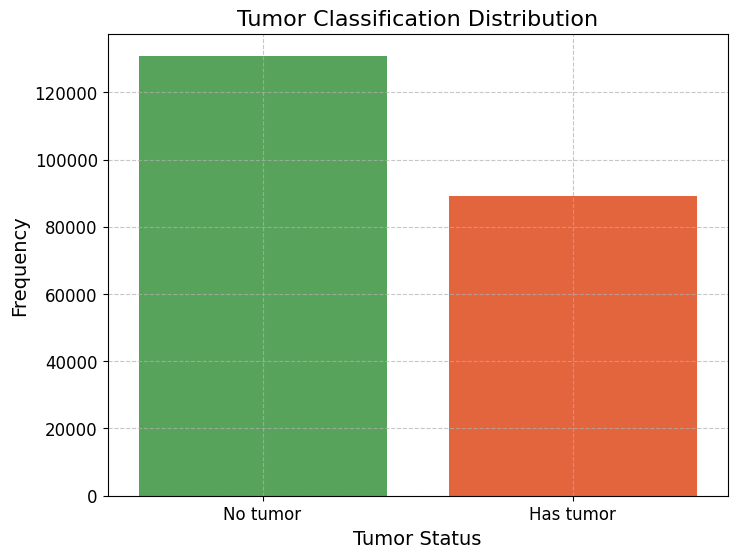

In [14]:
import seaborn as sns

# Count the occurrences of each label
label_counts = df_data['label'].value_counts()

# Map 0 to "No tumor" and 1 to "Has tumor"
label_counts.index = label_counts.index.map({0: 'No tumor', 1: 'Has tumor'})

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#4CAF50', '#FF5722'])

# Customizing the plot
plt.title('Tumor Classification Distribution', fontsize=16)
plt.xlabel('Tumor Status', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [15]:
df_data.head()

,label,path
id,,
f38a6374c348f90b587e046aac6079959adf3835,0,/train/f38a6374c348f90b587e046aac6079959adf383...
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/train/c18f2d887b7ae4f6742ee445113fa1aef383ed7...
755db6279dae599ebb4d39a9123cce439965282d,0,/train/755db6279dae599ebb4d39a9123cce439965282...
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e0...
068aba587a4950175d04c680d38943fd488d6a9d,0,/train/068aba587a4950175d04c680d38943fd488d6a9...


Below are sample images with and without the tumor. In some scans, the tumor cells can be very small. So we will need to use a deep neural network to identify the tumor in the images. Therefore, we will need to use a deep neural network to effectively identify the tumor in the images.

In [16]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):

    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """


    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols,
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=sample['path'].str[1:][j] #IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)
    plt.tight_layout()
    plt.show()

<ipython-input-16-5cbc7927b4fc>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  file=sample['path'].str[1:][j] #IMAGE_PATH + sample.iloc[j]['id'] + '.tif'


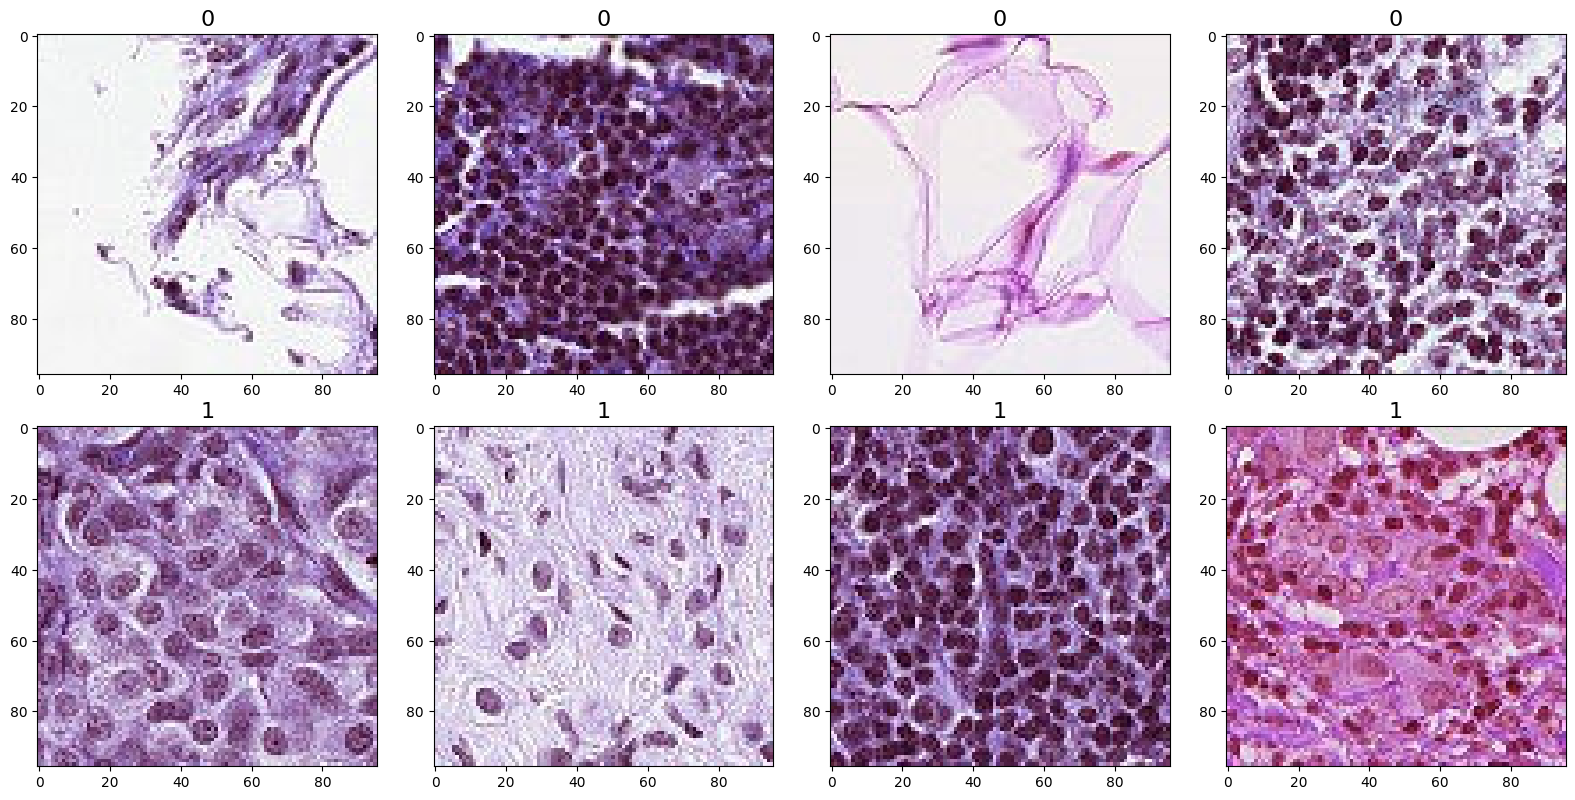

In [17]:
IMAGE_PATH = 'train/'

draw_category_images('label',4, df_data, IMAGE_PATH)

## Model Architecture

We will start by comparing a simple and a complex CNN model. Then, we will evaluate different optimization methods and tune the hyperparameters to improve performance.

The following models will use the ReLU activation for Convulation layers to incorporate non-linearity and sigmoid activation function for the output layer as we have a binary classification problem.

Below is the architecture of the models:

Simple model
- input Layer
- 3 Conv2D Layers with Relu activation function
- MaxPool Layer
- dropout

- Flatten Layer
- Dense layer with Relu activation function
- Dropout
- Final Dense layer with Sigmoid activation function

Complex Model
- input Layer
- 3 Conv2D Layers with Relu activation function
- MaxPool Layer
- dropout

- 3 Conv2D Layers with Relu activation function
- MaxPool Layer
- dropout

- Flatten Layer
- Dense layer with Relu activation function
- Dropout
- Final Dense layer with Sigmoid activation function

### Simple Model

In [18]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


simple_model = Sequential()
simple_model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
simple_model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
simple_model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
simple_model.add(MaxPooling2D(pool_size = pool_size))
simple_model.add(Dropout(dropout_conv))

simple_model.add(Flatten())
simple_model.add(Dense(256, activation = "relu"))
simple_model.add(Dropout(dropout_dense))
simple_model.add(Dense(2, activation = "sigmoid"))

simple_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 92, 92, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,589,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,608,962 (63.36 MB)

 Trainable params: 16,608,962 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
adam = keras.optimizers.Adam(learning_rate=0.001, name='ADAM')

simple_model.compile(adam, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
simple_model.fit(train_gen, validation_data = val_gen, epochs=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6189/6189 ━━━━━━━━━━━━━━━━━━━━ 476s 76ms/step - accuracy: 0.7798 - loss: 0.4896 - val_accuracy: 0.8524 - val_loss: 0.3553


In [23]:
from tensorflow.keras.optimizers import RMSprop
rms = RMSprop(learning_rate=0.001, name='RMSprop')

simple_model.compile(rms, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
simple_model.fit(train_gen, validation_data = val_gen, epochs=1)

6189/6189 ━━━━━━━━━━━━━━━━━━━━ 348s 56ms/step - accuracy: 0.5940 - loss: 0.6754 - val_accuracy: 0.5891 - val_loss: 0.6777


In [25]:
adam = keras.optimizers.Adam(learning_rate=0.01, name='ADAM')

simple_model.compile(adam, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
simple_model.fit(train_gen, validation_data = val_gen, epochs=1)

6189/6189 ━━━━━━━━━━━━━━━━━━━━ 352s 56ms/step - accuracy: 0.5947 - loss: 0.6755 - val_accuracy: 0.5891 - val_loss: 0.6781


In [26]:
from tensorflow.keras.optimizers import RMSprop
rms = RMSprop(learning_rate=0.01, name='RMSprop')

simple_model.compile(rms, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
simple_model.fit(train_gen, validation_data = val_gen, epochs=1)

6189/6189 ━━━━━━━━━━━━━━━━━━━━ 350s 56ms/step - accuracy: 0.5967 - loss: 0.6748 - val_accuracy: 0.5891 - val_loss: 0.6772


By using accuracy as the evaluation metric, we observe that with a learning rate of 0.001, the Adam optimization method outperforms RMSprop in terms of accuracy.

\
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{Model Name} & \textbf{Optimization Method} & \textbf{Learning Rate} & \textbf{Accuracy} & \textbf{Loss} \\
\hline
\text{Simple Model} & \text{ADAM} & 0.01 & \text{0.5947} & \text{0.6755} \\
\hline
\text{Simple Model} & \text{RMSprop} & 0.01 & \text{xxxx} & \text{xxxx} \\
\hline
\text{Simple Model} & \text{ADAM} & 0.001 & \text{0.7798} & \text{0.4896} \\
\hline
\text{Simple Model} & \text{RMSprop} & 0.001 & \text{0.5940} & \text{0.6754} \\
\hline
\end{array}





Thus, for the more complex model with 2 blocks of convolutional layers we will use Adam as the optmization method with a learning rate of 0.001.

## Complex Model

In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "sigmoid"))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 92, 92, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 43, 43, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 41, 41, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 39, 39, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 23104)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,914,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,027,138 (22.99 MB)

 Trainable params: 6,027,138 (22.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.001, name='ADAM')

model.compile(adam, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 92, 92, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 43, 43, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 41, 41, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 39, 39, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 23104)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,914,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,027,138 (22.99 MB)

 Trainable params: 6,027,138 (22.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train_gen, epochs=4)

Epoch 1/4
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 300s 47ms/step - accuracy: 0.8527 - loss: 0.3470
Epoch 2/4
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 298s 44ms/step - accuracy: 0.8735 - loss: 0.3040
Epoch 3/4
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 261s 42ms/step - accuracy: 0.8841 - loss: 0.2834
Epoch 4/4
4044/6189 ━━━━━━━━━━━━━━━━━━━━ 1:27 41ms/step - accuracy: 0.8908 - loss: 0.2707

In [ ]:
loss, accuracy = model.evaluate(val_gen)
print('Val accuracy: %.2f' % (accuracy))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


688/688 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.8907 - loss: 0.2755
Val accuracy: 0.89


## Results and Analysis

We developed both a simple and a complex model and experimented with different optimization methods and learning rates to improve model accuracy. Our findings show that the Adam optimization method with a learning rate of 0.001 yielded the highest accuracy. The Adam optimizer also provided better results in less time, as it converged more efficiently. This is because a lower learning rate allowed the model to stabilize and "bounce around" less during training. Finally, to further enhance the model, we added an additional block of convolutional layers, resulting in our final model below:

Complex Model
- input Layer
- 3 Conv2D Layers with Relu activation function
- MaxPool Layer
- dropout

- 3 Conv2D Layers with Relu activation function
- MaxPool Layer
- dropout

- Flatten Layer
- Dense layer with Relu activation function
- Dropout
- Final Dense layer with Sigmoid activation function

The table below illustrates how accuracy improves as we updated the optimization method, model architecture, and learning rate.



\
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{Model Name} & \textbf{Optimization Method} & \textbf{Learning Rate} & \textbf{Accuracy} & \textbf{Test Accuracy} & \textbf{Loss} \\
\hline
\text{Simple Model} & \text{RMSprop} & 0.01 & \text{0.5967} & \text{0.5891} & \text{0.6748} \\
\hline
\text{Simple Model} & \text{ADAM} & 0.01 & \text{0.5947} & \text{0.5891} & \text{0.6755} \\
\hline
\text{Simple Model} & \text{RMSprop} & 0.001 & \text{0.5940} & \text{0.5891} & \text{0.6754} \\
\hline
\text{Simple Model} & \text{ADAM} & 0.001 & \text{0.7798} & \text{0.8473} & \text{0.4896} \\
\hline
\text{Complex Model} & \text{ADAM} & 0.001 & \text{0.8908} & \text{0.9325} & \text{0.2707} \\
\hline
\end{array}

Below is the code to create a submission.csv file for the Kaggle Competition. That is how the test accuracy was calculated in the table.


In [ ]:
# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)

# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [ ]:
# Transfer the test images into image_dir

test_list = os.listdir('test')

for image in test_list:

    fname = image

    # source path to image
    src = os.path.join('test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

len(os.listdir('test_dir/test_images'))

57458

In [ ]:
test_path ='test_dir'
test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [ ]:
num_test_images = 57458

predictions = model.predict(test_gen, steps=num_test_images, verbose=1)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 185s 3ms/step


In [ ]:
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])


test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames


def extract_id(x):

    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]

    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

# Get the predicted labels
y_pred = df_preds['has_tumor_tissue']

image_id = df_preds['id']

df_pred.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,0.111196,0.824578,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.110423,0.931216,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.700862,0.373416,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.488631,0.574108,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.907519,0.272759,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [ ]:
submission = pd.DataFrame({'id':image_id,
                           'label':y_pred,
                          }).set_index('id')

submission.to_csv('submission.csv', columns=['label'])
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.824578
0000ec92553fda4ce39889f9226ace43cae3364e,0.931216
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.373416
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.574108
000270442cc15af719583a8172c87cd2bd9c7746,0.272759


## Conclusion

Lowering the learning rate while using the RMSprop optimization method did not improve accuracy. However, reducing the learning rate for the Adam optimization method significantly enhanced the model's performance. Due to limited computational resources, I only ran 4 epochs for the final model, but it showed consistent improvement in accuracy. In the future, I plan to run more epochs to further boost accuracy.

In conclusion, the final model achieved a test accuracy of 0.9375, which is a solid result.

## References

- Kaggle. Histopathologic Cancer Detection: Submissions. Kaggle, www.kaggle.com/competitions/histopathologic-cancer-detection/submissions. Accessed 28 Feb. 2025.

- Kaggle. Histopathologic Cancer Detection Using CNNs. Kaggle, https://www.kaggle.com/code/abhinand05/histopathologic-cancer-detection-using-cnns. Accessed 28 Feb. 2025.